# Weather prediction example

This notebook shows a simple way to predict time series data using a PredictLite neural network

(c) Mikko Kursula 2022. MIT License. 

In [1]:
# Enable automatic reloading (if changes are done in the model code)
%load_ext autoreload
%autoreload 2

# General
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Data source
import meteostat

# PredictLite
from predictlite.predictlite import PredictLite

### Get weather dataset

In [2]:
# Get hourly weather data
station_id = '02944'
start_dt = datetime(2012, 1, 1)
end_dt = datetime(2022, 1, 1)
dataset = meteostat.Hourly(station_id, start_dt, end_dt).fetch()
dataset.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2012-01-01 00:00:00,-5.5,-5.6,99.0,NaN,NaN,220.0,7.2,NaN,1007.6,NaN,NaN
2012-01-01 01:00:00,-5.2,-5.5,98.0,NaN,NaN,200.0,7.2,NaN,1008.0,NaN,NaN
2012-01-01 02:00:00,-5.2,-5.5,98.0,NaN,NaN,220.0,7.2,NaN,1008.3,NaN,NaN
2012-01-01 03:00:00,-6.0,-6.1,99.0,NaN,NaN,220.0,7.2,NaN,1008.6,NaN,NaN
2012-01-01 04:00:00,-4.6,-5.1,96.0,NaN,NaN,260.0,3.6,NaN,1009.0,NaN,NaN


### Setup and train PredictLite model 

In [14]:
model = PredictLite(
    input_signals=['temp', 'rhum'], 
    input_preprocessing={'temp' : 'z-norm', 'rhum' : 'z-norm'},
    input_length=48,
    datetime_embeddings=['month', 'hour'],
    output_signals=['temp', 'rhum'],
    output_length=24,
    resample_data=True,
    data_sample_period=3600,
    hidden_layer_n=2,
    train_sample_n=10000,
    test_sample_n=1000,
    epochs=20,
    random_seed=13,
    verbose=True,
)

model.fit(dataset)

Setting up preprocessing
Building dataset
Training the model
epoch:   0, train loss: 0.66701, test loss: 0.40785
epoch:   1, train loss: 0.31887, test loss: 0.28480
epoch:   2, train loss: 0.26240, test loss: 0.26264
epoch:   3, train loss: 0.24574, test loss: 0.25214
epoch:   4, train loss: 0.23696, test loss: 0.24551
epoch:   5, train loss: 0.22972, test loss: 0.24189
epoch:   6, train loss: 0.22470, test loss: 0.23910
epoch:   7, train loss: 0.22065, test loss: 0.23506
epoch:   8, train loss: 0.21676, test loss: 0.23122
epoch:   9, train loss: 0.21372, test loss: 0.23026
epoch:  10, train loss: 0.21163, test loss: 0.22807
epoch:  11, train loss: 0.20912, test loss: 0.22741
epoch:  12, train loss: 0.20707, test loss: 0.22820
epoch:  13, train loss: 0.20504, test loss: 0.22537
epoch:  14, train loss: 0.20382, test loss: 0.22516
epoch:  15, train loss: 0.20219, test loss: 0.22490
epoch:  16, train loss: 0.20025, test loss: 0.22203
epoch:  17, train loss: 0.19922, test loss: 0.22105
epo

In [17]:
model.model_summary()

Inputs:
	temp: 48
	rhum: 48
	month: Embedding(13, 20)
	hour: Embedding(24, 20)
MLP:
	Linear(in_features=136, out_features=136, bias=True)
	ReLU()
	Linear(in_features=136, out_features=136, bias=True)
	ReLU()
	Linear(in_features=136, out_features=48, bias=True)
Outputs:
	temp: 24
	rhum: 24


### Make prediction

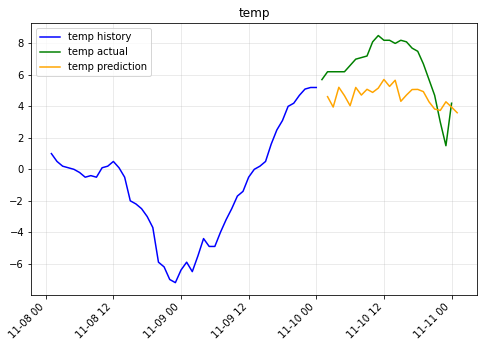

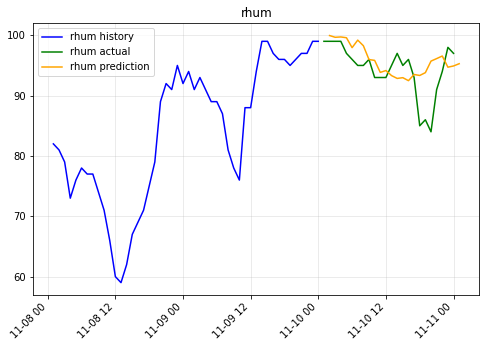

In [21]:
# Datetime for prediction start
prediction_time = datetime(2021, 11, 10, 1)

# Make prediction 
pred = model.predict(dataset, prediction_time)

# Plot data and prediction
pred_len = model.output_length
inp_len = model.input_length
for col in model.output_signals:
    
    ts_idx = dataset.index.get_loc(prediction_time, method='pad')
    plt.figure(figsize=(8, 5))
    plt.plot(
        dataset.index[ts_idx - inp_len : ts_idx].values, 
        dataset.iloc[ts_idx - inp_len : ts_idx][col].values, 
        color='blue', 
        label='{} history'.format(col)
    )
    plt.plot(
        dataset.index[ts_idx : ts_idx + pred_len].values, 
        dataset.iloc[ts_idx : ts_idx + pred_len][col].values, 
        color='green',
        label='{} actual'.format(col)
    )
    plt.plot(
        pred.index.values, 
        pred[col].values, 
        color='orange', 
        label='{} prediction'.format(col)
    )
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.title(col)
    plt.show()